In [1]:
import numpy as np
from scipy.io import loadmat
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
hf = h5py.File('/media/maria/DATA1/Documents/ZebraFish/subject_1/TimeSeries.h5', 'r')
#print(hf['absIx'])
neural_dat=np.array(hf['CellResp'])
del hf

In [3]:
regressors=loadmat('/media/maria/DATA1/Documents/ZebraFish/subject_1/data_full.mat')
cell_pos=regressors['data']['CellXYZ'][0][0]
missing_values=regressors['data']['IX_inval_anat'][0][0]
cell_pos=np.delete(cell_pos,missing_values,axis=0)

In [4]:
print(cell_pos)

[[1163 1013    1]
 [1140 1009    1]
 [1102 1007    1]
 ...
 [1044  276   29]
 [ 948  271   29]
 [1018  268   29]]


In [20]:
def circle(center_x,center_y,radius,h,k):
    within_circle=radius>np.sqrt((center_x-h)**2+(center_y-k)**2)
    #print(within_circle)
    return within_circle

In [48]:
center_x=cell_pos[83204][0]
center_y=cell_pos[83024][1]

boolean_arr=[]
for j in range(0,83205):
    boolean_ind=circle(center_x,center_y,100,cell_pos[j][0],cell_pos[j][1])
    boolean_arr.append(boolean_ind)
print(sum(boolean_arr))

/home/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in ushort_scalars
  


726


In [39]:
print(cell_pos.shape)

(83205, 3)


In [49]:
selected_cells=neural_dat[:,boolean_arr]

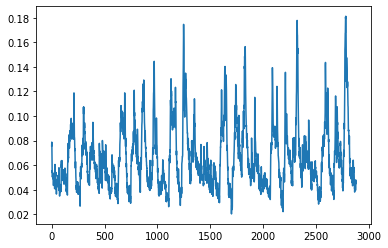

In [50]:
plt.plot(np.mean(selected_cells,axis=1))

In [ ]:
plt.plot(neural_dat[:100,83024])

In [59]:
def get_averages_of_sampled_cells(neural_dat,n_cells=1000):
    random=np.random.choice(83205,n_cells,replace=False).tolist()
    mean_arr=[]
    for ind in random:
        mean=compute_average_of_one_cell(neural_dat,ind)
        mean_arr.append(mean)
    return mean_arr
    
def compute_average_of_one_cell(neural_dat,cell_ind):    
    center_x=cell_pos[cell_ind][0]
    center_y=cell_pos[cell_ind][1]
    boolean_arr=[]
    for j in range(0,83205):
        boolean_ind=circle(center_x,center_y,100,cell_pos[j][0],cell_pos[j][1])
        boolean_arr.append(boolean_ind)
    selected_cells=neural_dat[:,boolean_arr]
    mean=np.mean(selected_cells,axis=1)
    return mean

In [60]:
import time
start=time.time()
mean_arr=get_averages_of_sampled_cells(neural_dat,n_cells=1000)
end=time.time()
print(end-start)

/home/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in ushort_scalars
  


878.1590750217438


In [65]:
mean_arr=np.array(mean_arr)
np.save('mean_arr.npy',mean_arr)

# Decompositions

(1, 2880)
(2880, 2)


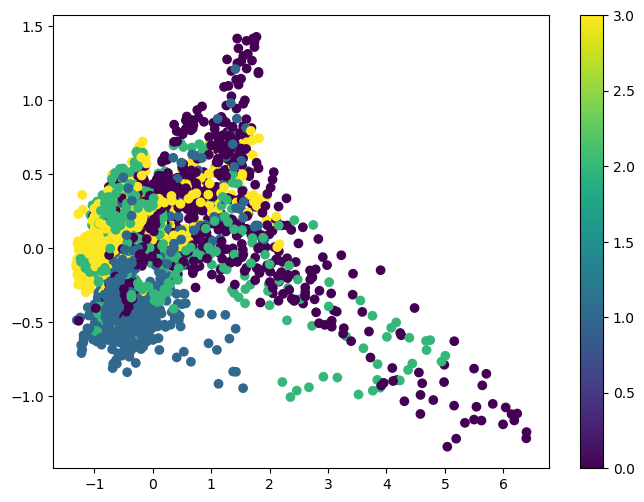

In [71]:
stim_dat=loadmat('/media/maria/DATA1/Documents/ZebraFish/subject_1/data_full.mat')['data']['stim_full'][0][0]
print(stim_dat.shape)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca=PCA(n_components=2)
pcs=pca.fit_transform(mean_arr.T)
print(pcs.shape)
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(pcs[:, 0], pcs[:, 1], c=stim_dat.flatten())
#plt.title('Variational Autoencoder')
plt.colorbar()
plt.show()

In [68]:
print(mean_arr.shape)

(1000, 2880)


In [64]:
print(mean_arr.shape)

AttributeError: 'list' object has no attribute 'shape'

In [74]:
beh_dat=loadmat('/media/maria/DATA1/Documents/ZebraFish/subject_1/data_full.mat')['data']['Behavior_full'][0][0]
def train_test_split(NT):
        nsegs = 20
        nt=NT
        nlen  = nt/nsegs
        ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
        itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
        itrain = np.ones(nt, np.bool)
        itrain[itest] = 0
        return itrain, itest
itrain,itest=train_test_split(beh_dat.shape[1])
beh_train=beh_dat[:,itrain]
beh_test=beh_dat[:,itest]
stim_train=stim_dat[:,itrain].astype('float64')
stim_test=stim_dat[:,itest].astype('float64')
print(mean_arr.shape)
neural_train=mean_arr[:,itrain]
neural_test=mean_arr[:,itest]
print('Training set size: ',beh_train.shape[1])
print('Test set size: ',beh_test.shape[1])

(1000, 2880)
Training set size:  2160
Test set size:  720


In [106]:
covM = np.matmul(stim_train, stim_train.T)
lam = 1e5 # regularizer
covM += lam*np.eye(stim_train.shape[0])
A = np.linalg.solve(covM, np.matmul(stim_train, neural_train.T))
print(A)
pred = np.matmul(A.T,stim_test)
stim_corr_neurons=[]
for j in range(0,pred.shape[0]):
    stim_corr_neurons.append(np.corrcoef(pred[j,:],neural_test[j,:])[0,1])

[[0.00216789 0.00210773 0.00203027 0.00192881 0.00227511 0.00175056
  0.00218755 0.00214619 0.00201866 0.0019678  0.0019946  0.00197805
  0.00198005 0.00231963 0.0020535  0.00245664 0.00192098 0.00215866
  0.0022041  0.00221983 0.00206626 0.00259649 0.00229713 0.0019369
  0.00208582 0.00197099 0.00250576 0.00181509 0.00214557 0.00221543
  0.00239372 0.00190976 0.00193259 0.00225058 0.00192599 0.00160126
  0.00260624 0.00212867 0.00259105 0.0029764  0.00302006 0.00534757
  0.00195249 0.00223827 0.00172973 0.00226058 0.00251342 0.00204211
  0.0022927  0.00219781 0.00263979 0.00251353 0.00196283 0.00186628
  0.00229705 0.00195618 0.00205431 0.00217119 0.00219765 0.00198513
  0.0027354  0.00224485 0.00340338 0.0022207  0.00188656 0.00185915
  0.00240329 0.00201554 0.00215803 0.00271204 0.00258016 0.00189183
  0.00250392 0.00231232 0.00254481 0.00200502 0.00176431 0.00255934
  0.00251691 0.00164325 0.00372608 0.00246473 0.00202964 0.00190921
  0.00181059 0.00243421 0.00196114 0.00191454 0.0

In [108]:
covM = np.matmul(beh_train, beh_train.T)
lam = 1e5 # regularizer
covM += lam*np.eye(beh_train.shape[0])
A = np.linalg.solve(covM, np.matmul(beh_train, neural_train.T))
pred = np.matmul(A.T,beh_test)
beh_corr_neurons=[]
for j in range(0,pred.shape[0]):
    beh_corr_neurons.append(np.corrcoef(pred[j,:],neural_test[j,:])[0,1])

Text(0, 0.5, 'Stimulus prediction correlations')

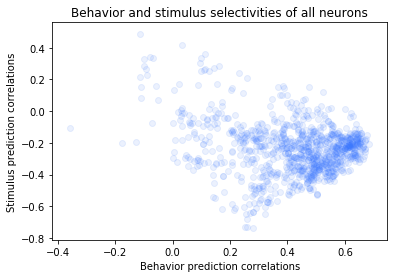

In [109]:
plt.scatter(beh_corr_neurons,stim_corr_neurons,alpha=0.1,color='xkcd:lightish blue')
plt.title('Behavior and stimulus selectivities of all neurons')
plt.xlabel('Behavior prediction correlations')
plt.ylabel('Stimulus prediction correlations')

# PCA

In [110]:
from factorization import PCA
algorithm = PCA(k=100)
v_pca,u_pca = algorithm.fit(neural_train.T)

In [111]:
covM = np.matmul(beh_train, beh_train.T)
lam = 1e5 # regularizer
covM += lam*np.eye(beh_train.shape[0])
A = np.linalg.solve(covM, np.matmul(beh_train, v_pca))
Vpred_beh_pca = np.matmul(A.T, beh_test)
beh_corr_lst_pca=[]
v_g=u_pca@neural_test
for j in range(0,100):
    beh_corr_lst_pca.append(np.corrcoef(Vpred_beh_pca[j,:],v_g[j,:])[0,1])

In [112]:
covM = np.matmul(stim_train, stim_train.T)
lam = 1e5 # regularizer
covM += lam*np.eye(stim_train.shape[0])
A = np.linalg.solve(covM, np.matmul(stim_train, v_pca))
Vpred_stim_pca = np.matmul(A.T, stim_test)
stim_corr_lst_pca=[]
for j in range(0,100):
    stim_corr_lst_pca.append(np.corrcoef(Vpred_stim_pca[j,:],v_g[j,:])[0,1])

Text(0, 0.5, 'Stimulus prediction correlations')

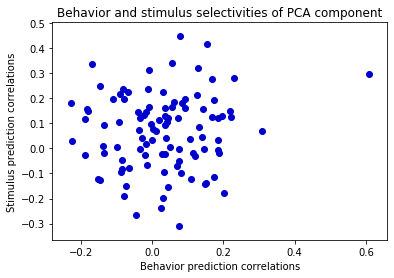

In [113]:
plt.scatter(beh_corr_lst_pca,stim_corr_lst_pca,color='#0000CC')
plt.title('Behavior and stimulus selectivities of PCA component')
plt.xlabel('Behavior prediction correlations')
plt.ylabel('Stimulus prediction correlations')

# ICA

In [138]:
from factorization import ICA
algorithm = ICA(k=99)
v_ica,u_ica = algorithm.fit(neural_train.T)

/home/maria/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


In [139]:
covM = np.matmul(beh_train, beh_train.T)
lam = 1e5 # regularizer
covM += lam*np.eye(beh_train.shape[0])
A = np.linalg.solve(covM, np.matmul(beh_train, v_ica))
Vpred_beh_ica = np.matmul(A.T, beh_test)
beh_corr_lst_ica=[]
v_g=u_ica@neural_test
for j in range(0,99):
    beh_corr_lst_ica.append(np.corrcoef(Vpred_beh_ica[j,:],v_g[j,:])[0,1])

In [140]:
covM = np.matmul(stim_train, stim_train.T)
lam = 1e5 # regularizer
covM += lam*np.eye(stim_train.shape[0])
A = np.linalg.solve(covM, np.matmul(stim_train, v_ica))
Vpred_stim_ica = np.matmul(A.T, stim_test)
stim_corr_lst_ica=[]
for j in range(0,99):
    stim_corr_lst_ica.append(np.corrcoef(Vpred_stim_ica[j,:],v_g[j,:])[0,1])

Text(0, 0.5, 'Stimulus prediction correlations')

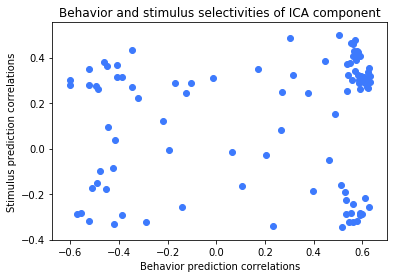

In [141]:
plt.scatter(beh_corr_lst_ica,stim_corr_lst_ica,color='xkcd:lightish blue')
plt.title('Behavior and stimulus selectivities of ICA component')
plt.xlabel('Behavior prediction correlations')
plt.ylabel('Stimulus prediction correlations')

# EP

In [143]:
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
ep=EnsemblePursuit(n_components=100,lam=0.01,n_kmeans=100)
ep.fit(neural_train.T)

obtained 100 PCs in 0.3390 seconds
initialized 100 clusters with k-means in 0.4367 seconds
ensemble 0, time 0.30, nr neurons 965, EV 0.5611
ensemble 25, time 2.62, nr neurons 154, EV 0.8474
ensemble 50, time 3.84, nr neurons 26, EV 0.8928
ensemble 75, time 4.77, nr neurons 9, EV 0.9155
ensemble 99, time 5.54, nr neurons 4, EV 0.9301
average sparsity is 0.0726


In [144]:
V=ep.components_
U=ep.weights

In [145]:
covM = np.matmul(beh_train, beh_train.T)
lam = 1e5 # regularizer
covM += lam*np.eye(beh_train.shape[0])
A = np.linalg.solve(covM, np.matmul(beh_train, V))
Vpred_beh = np.matmul(A.T, beh_test)
beh_corr_lst=[]
V_g=U.T@neural_test[:10000,:]
for j in range(0,100):
    beh_corr_lst.append(np.corrcoef(Vpred_beh[j,:],V_g[j,:])[0,1])

In [146]:
covM = np.matmul(stim_train, stim_train.T)
lam = 1e5 # regularizer
covM += lam*np.eye(stim_train.shape[0])
A = np.linalg.solve(covM, np.matmul(stim_train, V))
Vpred_stim = np.matmul(A.T, stim_test)
stim_corr_lst=[]
print(V_g.shape)
for j in range(0,100):
    stim_corr_lst.append(np.corrcoef(Vpred_stim[j,:],V_g[j,:])[0,1])

(100, 720)


Text(0, 0.5, 'Stimulus prediction correlations')

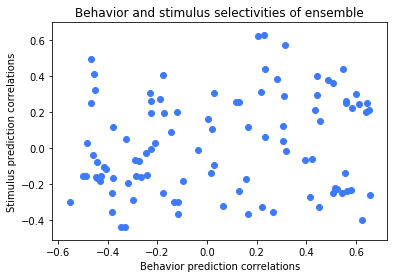

In [147]:
plt.scatter(beh_corr_lst,stim_corr_lst,color='xkcd:lightish blue')
plt.title('Behavior and stimulus selectivities of ensemble')
plt.xlabel('Behavior prediction correlations')
plt.ylabel('Stimulus prediction correlations')